Here, I will be implenting MLP with different Activation functions and compare the accuracies.

I will implement three functions:

1.   Sigmoid
2.   tanh
1.   Log Likehihood





Epoch 1: Train Acc = 4.10%, Val Acc = 4.64%
Epoch 2: Train Acc = 10.07%, Val Acc = 13.25%
Epoch 3: Train Acc = 14.63%, Val Acc = 23.18%
Epoch 4: Train Acc = 26.35%, Val Acc = 35.10%
Epoch 5: Train Acc = 39.27%, Val Acc = 49.01%
Epoch 6: Train Acc = 59.87%, Val Acc = 72.85%
Epoch 7: Train Acc = 81.10%, Val Acc = 91.39%
Epoch 8: Train Acc = 93.57%, Val Acc = 98.68%
Epoch 9: Train Acc = 99.20%, Val Acc = 99.34%
Epoch 10: Train Acc = 99.37%, Val Acc = 99.34%
Epoch 11: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 12: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 13: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 14: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 15: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 16: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 17: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 18: Train Acc = 99.89%, Val Acc = 100.00%
Epoch 19: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 20: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 21: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 22: Tra

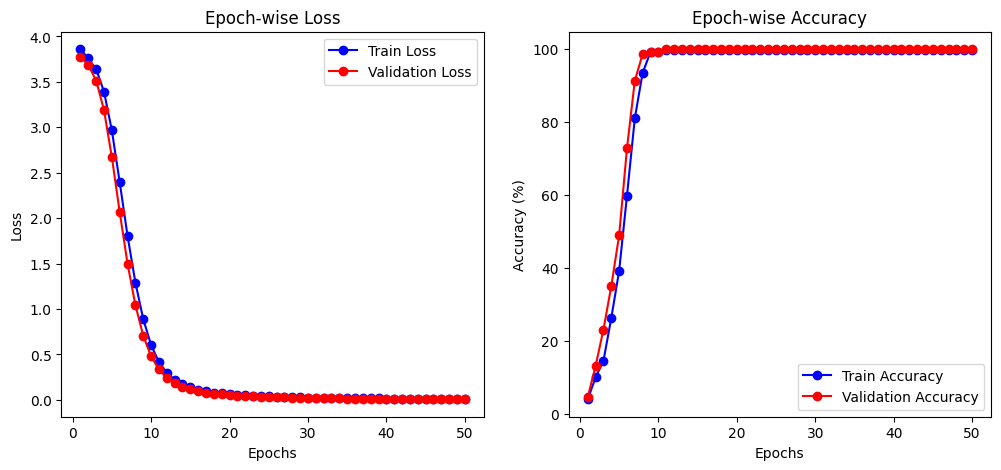

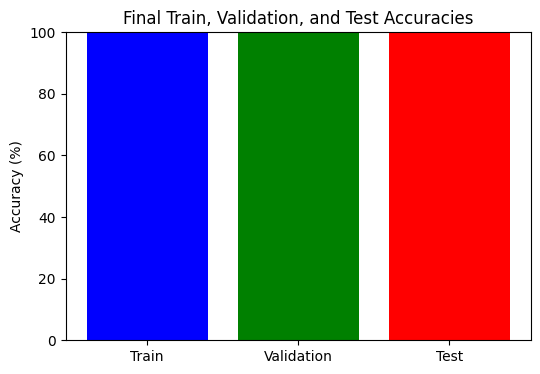

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

#Loading Data
X_lda = np.load('X_lda.npy')
y = np.load('y_labels.npy')

# Split: 70% Train, 30% Temp; then split Temp into 20% Test and 10% Validation
X_train, X_temp, y_train, y_temp = train_test_split(X_lda, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)


def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)

#ANN with two hidden Layers
#Sigmoid as activation function
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

#PyTorch Tensor and Dataloader declarations
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_std, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_std, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


input_size = X_train_std.shape[1]
model = ANN(input_size=input_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training data
num_epochs = 50
epoch_train_losses = []
epoch_val_losses = []
epoch_train_accs = []
epoch_val_accs = []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        total_correct += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct * 100 / total_samples
    epoch_train_losses.append(train_loss)
    epoch_train_accs.append(train_acc)

    # Validation
    model.eval()
    total_val_loss, total_val_correct, total_val_samples = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            total_val_correct += (predicted == batch_y).sum().item()
            total_val_samples += batch_y.size(0)
    val_loss = total_val_loss / len(val_loader)
    val_acc = total_val_correct * 100 / total_val_samples
    epoch_val_losses.append(val_loss)
    epoch_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

#Testing Set Eveluation and Results
model.eval()
total_test_correct, total_test_samples = 0, 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predicted = torch.argmax(outputs, dim=1)
        total_test_correct += (predicted == batch_y).sum().item()
        total_test_samples += batch_y.size(0)
test_acc = total_test_correct * 100 / total_test_samples


final_train_acc = epoch_train_accs[-1]
final_val_acc = epoch_val_accs[-1]
final_test_acc = test_acc

print("\nFinal Accuracies:")
print(f"Train Accuracy: {final_train_acc:.2f}%")
print(f"Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {final_test_acc:.2f}%")

#Plotting epoch wise accuracy and loss curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_train_losses, label="Train Loss", marker="o", color="blue")
plt.plot(epochs, epoch_val_losses, label="Validation Loss", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch-wise Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(epochs, epoch_val_accs, label="Validation Accuracy", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Epoch-wise Accuracy")
plt.legend()

plt.show()

#Final Accuracy and Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(["Train", "Validation", "Test"], [final_train_acc, final_val_acc, final_test_acc],
        color=["blue", "green", "red"])
plt.ylabel("Accuracy (%)")
plt.title("Final Train, Validation, and Test Accuracies")
plt.ylim(0, 100)
plt.show()

Epoch 1: Train Acc = 70.29%, Val Acc = 98.01%
Epoch 2: Train Acc = 99.15%, Val Acc = 100.00%
Epoch 3: Train Acc = 99.72%, Val Acc = 100.00%
Epoch 4: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 5: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 6: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 7: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 8: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 9: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 10: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 11: Train Acc = 99.66%, Val Acc = 99.34%
Epoch 12: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 13: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 14: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 15: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 16: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 17: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 18: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 19: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 20: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 21: Train Acc = 99.77%, Val Acc = 100.00%
Epo

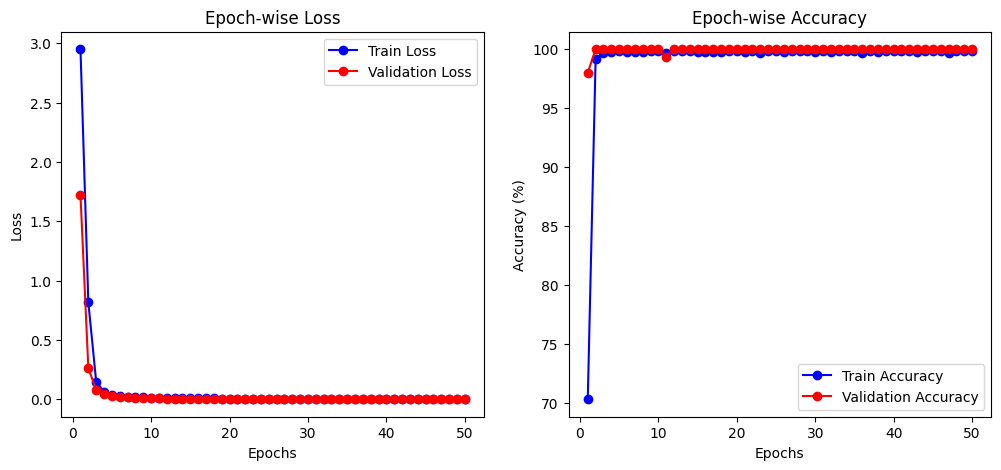

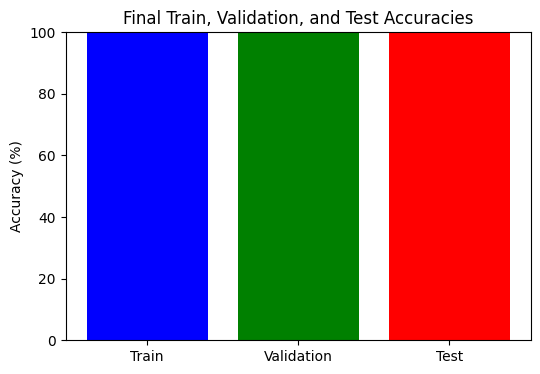

In [ ]:
#Using tanh as activation function

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


X_lda = np.load('X_lda.npy')
y = np.load('y_labels.npy')

# Split: 70% Train, 30% Temp; then split Temp into 20% Test and 10% Validation
X_train, X_temp, y_train, y_temp = train_test_split(X_lda, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)


def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)

#ANN with two hidden Layers
#Tanh as activation function
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_std, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_std, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


input_size = X_train_std.shape[1]
model = ANN(input_size=input_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training the model
num_epochs = 50
epoch_train_losses = []
epoch_val_losses = []
epoch_train_accs = []
epoch_val_accs = []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        total_correct += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct * 100 / total_samples
    epoch_train_losses.append(train_loss)
    epoch_train_accs.append(train_acc)

    # Validation
    model.eval()
    total_val_loss, total_val_correct, total_val_samples = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            total_val_correct += (predicted == batch_y).sum().item()
            total_val_samples += batch_y.size(0)
    val_loss = total_val_loss / len(val_loader)
    val_acc = total_val_correct * 100 / total_val_samples
    epoch_val_losses.append(val_loss)
    epoch_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

#Testing Set Evaluation and Results
model.eval()
total_test_correct, total_test_samples = 0, 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predicted = torch.argmax(outputs, dim=1)
        total_test_correct += (predicted == batch_y).sum().item()
        total_test_samples += batch_y.size(0)
test_acc = total_test_correct * 100 / total_test_samples


final_train_acc = epoch_train_accs[-1]
final_val_acc = epoch_val_accs[-1]
final_test_acc = test_acc

print("\nFinal Accuracies:")
print(f"Train Accuracy: {final_train_acc:.2f}%")
print(f"Validation Accuracy: {final_val_acc:.2f}%")
print(f"Test Accuracy: {final_test_acc:.2f}%")

#Epoch-wise Loss and Accuracy Curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_train_losses, label="Train Loss", marker="o", color="blue")
plt.plot(epochs, epoch_val_losses, label="Validation Loss", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch-wise Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(epochs, epoch_val_accs, label="Validation Accuracy", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Epoch-wise Accuracy")
plt.legend()

plt.show()

#Final Bar Chart and accuracies
plt.figure(figsize=(6, 4))
plt.bar(["Train", "Validation", "Test"], [final_train_acc, final_val_acc, final_test_acc],
        color=["blue", "green", "red"])
plt.ylabel("Accuracy (%)")
plt.title("Final Train, Validation, and Test Accuracies")
plt.ylim(0, 100)
plt.show()

Epoch 1: Train Acc = 50.03%, Val Acc = 90.73%
Epoch 2: Train Acc = 96.70%, Val Acc = 99.34%
Epoch 3: Train Acc = 99.72%, Val Acc = 100.00%
Epoch 4: Train Acc = 99.72%, Val Acc = 100.00%
Epoch 5: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 6: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 7: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 8: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 9: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 10: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 11: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 12: Train Acc = 99.72%, Val Acc = 100.00%
Epoch 13: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 14: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 15: Train Acc = 99.72%, Val Acc = 100.00%
Epoch 16: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 17: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 18: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 19: Train Acc = 99.77%, Val Acc = 100.00%
Epoch 20: Train Acc = 99.83%, Val Acc = 100.00%
Epoch 21: Train Acc = 99.77%, Val Acc = 100.00%
Epo

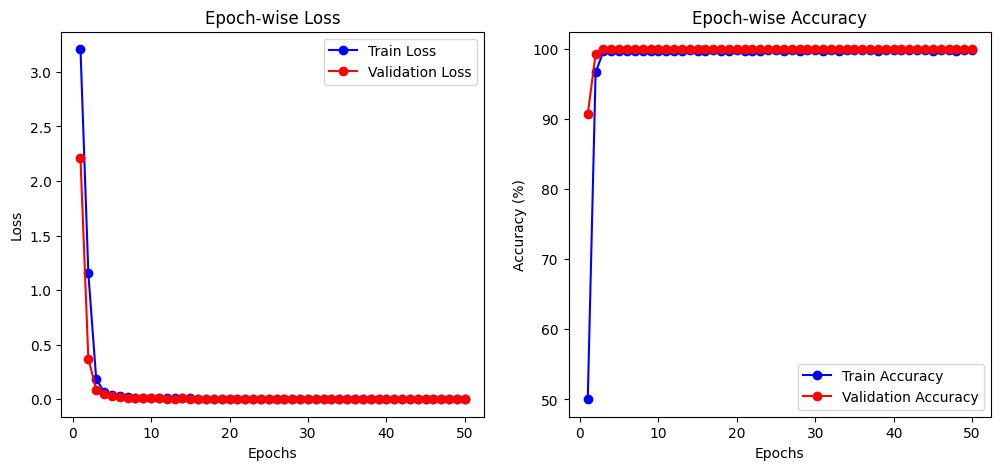

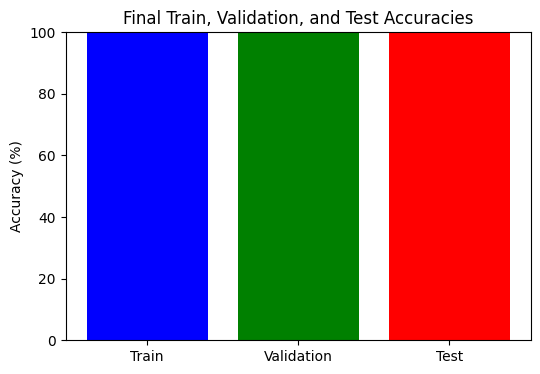


Final Accuracies:
Train Accuracy: 99.83%
Validation Accuracy: 100.00%
Test Accuracy: 100.00%


In [ ]:
'''
ReLU in the first hidden layer, Tanh in the second hidden layer, and Log-Likelihood loss manually implemented.
The output layer uses Softmax for probabilities.
'''

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


X_lda = np.load('X_lda.npy')
y = np.load('y_labels.npy')

X_train, X_temp, y_train, y_temp = train_test_split(X_lda, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)


def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)

# ANN Model with ReLU, Tanh, and Log-Likelihood Loss

class ANN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # First hidden layer with ReLU
        x = torch.tanh(self.fc2(x))  # Second hidden layer with Tanh
        x = self.fc3(x)  # Logits (raw scores before softmax)
        return x

# Custom Log-Likelihood Loss
class LogLikelihoodLoss(nn.Module):
    def __init__(self):
        super(LogLikelihoodLoss, self).__init__()

    def forward(self, predictions, targets):
        predictions = torch.log_softmax(predictions, dim=1)  # Apply log-softmax
        loss = -predictions[torch.arange(predictions.shape[0]), targets]  # Negative log likelihood
        return loss.mean()


batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_std, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_std, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


input_size = X_train_std.shape[1]
model = ANN(input_size=input_size).to(device)

criterion = LogLikelihoodLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training the model
num_epochs = 50
epoch_train_losses = []
epoch_val_losses = []
epoch_train_accs = []
epoch_val_accs = []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        total_correct += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct * 100 / total_samples
    epoch_train_losses.append(train_loss)
    epoch_train_accs.append(train_acc)

    model.eval()
    total_val_loss, total_val_correct, total_val_samples = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            total_val_correct += (predicted == batch_y).sum().item()
            total_val_samples += batch_y.size(0)
    val_loss = total_val_loss / len(val_loader)
    val_acc = total_val_correct * 100 / total_val_samples
    epoch_val_losses.append(val_loss)
    epoch_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

# Testing Set Evaluation
model.eval()
total_test_correct, total_test_samples = 0, 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predicted = torch.argmax(outputs, dim=1)
        total_test_correct += (predicted == batch_y).sum().item()
        total_test_samples += batch_y.size(0)
test_acc = total_test_correct * 100 / total_test_samples


final_train_acc = epoch_train_accs[-1]
final_val_acc = epoch_val_accs[-1]
final_test_acc = test_acc

#Epoch-wise Loss and Accuracy Curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_train_losses, label="Train Loss", marker="o", color="blue")
plt.plot(epochs, epoch_val_losses, label="Validation Loss", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch-wise Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(epochs, epoch_val_accs, label="Validation Accuracy", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Epoch-wise Accuracy")
plt.legend()

plt.show()

#Final Bar Chart and Accuracies
plt.figure(figsize=(6, 4))
plt.bar(["Train", "Validation", "Test"], [final_train_acc, final_val_acc, final_test_acc],
        color=["blue", "green", "red"])
plt.ylabel("Accuracy (%)")
plt.title("Final Train, Validation, and Test Accuracies")
plt.ylim(0, 100)
plt.show()

print("\nFinal Accuracies:")
print(f"Train Accuracy: {epoch_train_accs[-1]:.2f}%")
print(f"Validation Accuracy: {epoch_val_accs[-1]:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")